In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('poster')

In [28]:
import json
import os
import glob
import re
import numpy as np

In [3]:
import tarfile

In [4]:
def decode(content):
    lines = content.split('\n')
    
    stats = list(filter(lambda L: L.startswith('{"startupTime"'), lines))
    stats = json.loads(stats[0])
    
    L = list(filter(lambda x: x.startswith('{'),lines))
    breakdown_stats = json.loads(L[0])
    
    task_lines = filter(lambda L: 'LAMBDA task' in L, lines)
    
    def lam_info(line):
        m = re.search('(\d\.\d+)s', line)
        time = float(m[1])
        
        uid = line[line.find('id: ')+4:]
        uid = uid[:uid.find(']')]
        
        
        return {'time': time, 'id': uid}
    
    tasks = map(lam_info, task_lines)
    df_tasks = pd.DataFrame(tasks)
    
    # how many unique containers were launched?
    num_unique_containers = len(df_tasks['id'].unique())
    
    # what was the mean execution time per container?
    # (distribution)
    task_time_mean = df_tasks['time'].mean()
    task_time_std = df_tasks['time'].std()
    
    container_reuse_min = int(df_tasks.groupby('id').count().min())
    container_reuse_max = int(df_tasks.groupby('id').count().max())
    
    # could also do some fancier stats here, i.e. histogram/binning on reuse!
    
    row = stats
    row.update({'num_unique_containers' : num_unique_containers,
           'task_time_mean' : task_time_mean,
           'task_time_std': task_time_std,
           'num_tasks':len(df_tasks),
           'container_reuse_min' : container_reuse_min,
           'container_reuse_max': container_reuse_max,
           'breakdown_stats' : breakdown_stats})
    return row

In [5]:
rows = []
with tarfile.open('tuplex-results.tar.gz') as tf:
    for name in filter(lambda name: name.endswith('.txt') and name.startswith('run'), tf.getnames()):
        fp = tf.extractfile(name)
        if fp is not None:
            content = fp.read().decode('utf-8')
            
            _, run, _, size, mode = name.split('-')
            run = int(run)
            size = int(size.replace('mb', ''))
            mode = mode.replace('.txt', '')
            run, size, mode
            
            row = {'run' : run, 'size' : size, 'mode':mode, 'framework':'tuplex'}
            
            row.update(decode(content))
            rows.append(row)
#             row = json.loads(content)
#             row['name'] = name
#             rows.append(row)

In [6]:
df = pd.DataFrame(rows)

In [7]:
df['type'] = df['mode']
df['job_time'] = df['jobTime']

In [8]:
df.groupby(['size', 'mode']).mean()

run  startupTime    jobTime  num_unique_containers  \
size  mode                                                       
3000  cold  3.0     0.064736  27.108625                  102.8   
      warm  3.0     0.070978  25.536860                  100.0   
5000  cold  3.0     0.070534  25.155967                  104.2   
      warm  3.0     0.072199  23.751910                  102.6   
10000 cold  3.0     0.068485  25.577497                  105.4   
      warm  3.0     0.080214  25.127351                  102.2   

            task_time_mean  task_time_std  num_tasks  container_reuse_min  \
size  mode                                                                  
3000  cold        4.766631       0.339352      400.0                  2.0   
      warm        4.973633       0.474070      400.0                  3.0   
5000  cold        4.797372       0.392640      400.0                  1.8   
      warm        4.748262       0.285700      400.0                  2.6   
10000 cold        4.759836       0.278665      400.0                  2.0   
      warm        4.762591       0.441136      400.0                  2.6   

            container_reuse_max   job_time  
size  mode                                  
3000  cold                  4.6  27.108625  
      warm                  5.0  25.536860  
5000  cold                  5.0  25.155967  
      warm                  4.6  23.751910  
10000 cold                  4.4  25.577497  
      warm                  5.0  25.127351

In [9]:
# other interesting stats:
# => max concurrency (via cloudwatch)

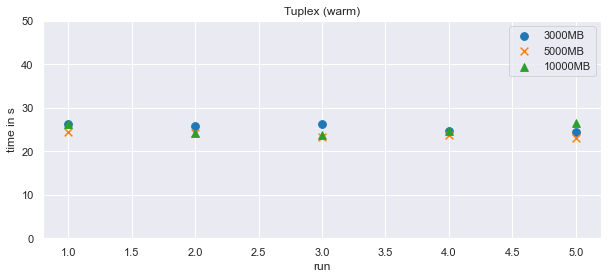

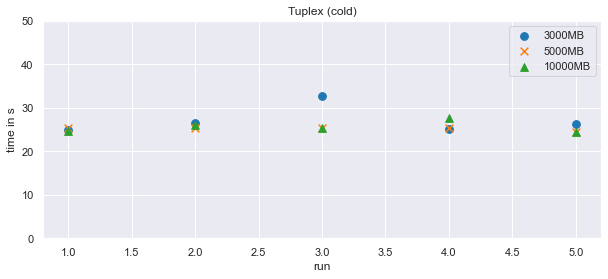

In [10]:
import itertools

sns.set_style('darkgrid')
sns.set_context('notebook')
def plot_df(df, exp_type='warm'): 
    plt.figure(figsize=(10, 4))
    plt.title('Tuplex ({})'.format(exp_type))
    
    markers = itertools.cycle('ox^')
    
    for group_name, group in df[df['type'] == exp_type].groupby('size'):

        #plt.plot(label=group_name)
        #print(group_name)
        group = group.sort_values('run')
        plt.scatter(group['run'], group['job_time'], 60, marker=next(markers), label='{}MB'.format(group_name))
    plt.legend()
    plt.xlabel('run')
    plt.ylabel('time in s')

    plt.ylim(0, 50)
plot_df(df, 'warm')
plot_df(df, 'cold')

In [11]:
df['framework'] = 'Tuplex'

In [12]:
df.to_csv('tuplex_results.csv', index=None)

### Per task analysis for Tuplex

In [16]:
keys = [k for k in list(df['breakdown_stats'].iloc[0].keys()) if k != '07_process_file_']

In [17]:
keys

['00_decode_request',
 '01_decode_transform_stage',
 '02_gather_uris_and_register_symbols',
 '03_parse_and_verify_module',
 '04_compile_function',
 '05_initialize_stage_and_executor',
 '06_initialize_file_reader',
 '08_write_output',
 '09_release_stage']

In [18]:
for k in keys:
    df[k] = df['breakdown_stats'].apply(lambda x: x[k]['mean'])

In [43]:
def extract_task(x):
    times = np.array(list(map(lambda t: t[1]['mean'], x.items())))
    return times.mean()

In [47]:
df['07_process_file_'] = df['breakdown_stats'].apply(lambda t: extract_task(t['07_process_file_']))

In [50]:
sns.set_style('darkgrid')
sns.set_context('notebook')
def plot_df(df, exp_type='warm'): 
    plt.figure(figsize=(10, 4))
    plt.title('Tuplex ({})'.format(exp_type))
    
    markers = itertools.cycle('ox^')
    
    for group_name, group in df[df['type'] == exp_type].groupby('size'):

        #plt.plot(label=group_name)
        #print(group_name)
        group = group.sort_values('run')
        plt.scatter(group['run'], group['job_time'], 60, marker=next(markers), label='{}MB'.format(group_name))
    plt.legend()
    plt.xlabel('run')
    plt.ylabel('time in s')

    plt.ylim(0, 50)
plot_df
# plot_df(df, 'warm')
# plot_df(df, 'cold')

<function __main__.plot_df(df, exp_type='warm')>

In [51]:
df.groupby(['type', 'size']).mean()

run  startupTime    jobTime  num_unique_containers  \
type size                                                        
cold 3000   3.0     0.064736  27.108625                  102.8   
     5000   3.0     0.070534  25.155967                  104.2   
     10000  3.0     0.068485  25.577497                  105.4   
warm 3000   3.0     0.070978  25.536860                  100.0   
     5000   3.0     0.072199  23.751910                  102.6   
     10000  3.0     0.080214  25.127351                  102.2   

            task_time_mean  task_time_std  num_tasks  container_reuse_min  \
type size                                                                   
cold 3000         4.766631       0.339352      400.0                  2.0   
     5000         4.797372       0.392640      400.0                  1.8   
     10000        4.759836       0.278665      400.0                  2.0   
warm 3000         4.973633       0.474070      400.0                  3.0   
     5000         4.748262       0.285700      400.0                  2.6   
     10000        4.762591       0.441136      400.0                  2.6   

            container_reuse_max   job_time  00_decode_request  \
type size                                                       
cold 3000                   4.6  27.108625           0.005087   
     5000                   5.0  25.155967           0.005191   
     10000                  4.4  25.577497           0.005047   
warm 3000                   5.0  25.536860           0.002592   
     5000                   4.6  23.751910           0.003076   
     10000                  5.0  25.127351           0.003078   

            01_decode_transform_stage  02_gather_uris_and_register_symbols  \
type size                                                                    
cold 3000                    0.000485                             0.000006   
     5000                    0.000531                             0.000006   
     10000                   0.000494                             0.000006   
warm 3000                    0.000100                             0.000006   
     5000                    0.000179                             0.000006   
     10000                   0.000179                             0.000005   

            03_parse_and_verify_module  04_compile_function  \
type size                                                     
cold 3000                     0.007700             0.077819   
     5000                     0.007934             0.078722   
     10000                    0.007731             0.077523   
warm 3000                     0.002036             0.066186   
     5000                     0.003145             0.067415   
     10000                    0.003201             0.066618   

            05_initialize_stage_and_executor  06_initialize_file_reader  \
type size                                                                 
cold 3000                           0.000026                   0.000014   
     5000                           0.000050                   0.000016   
     10000                          0.000033                   0.000014   
warm 3000                           0.000028                   0.000013   
     5000                           0.000024                   0.000014   
     10000                          0.000042                   0.000013   

            08_write_output  09_release_stage  07_process_file_  
type size                                                        
cold 3000          0.118247          0.000038          4.653312  
     5000          0.121662          0.000040          4.685634  
     10000         0.119609          0.000044          4.640149  
warm 3000          0.121710          0.000034          4.856859  
     5000          0.121017          0.000039          4.627174  
     10000         0.119611          0.000047          4.652904

In [52]:
df['other_time'] = df['00_decode_request'] + df['01_decode_transform_stage'] + \
df['09_release_stage'] + df['06_initialize_file_reader'] + df['05_initialize_stage_and_executor']

In [53]:
df['compile_time'] = df['03_parse_and_verify_module'] + df['04_compile_function']

In [54]:
df['write_time'] = df['08_write_output']

In [56]:
df['process_time'] = df['07_process_file_']
df['job_time']= df['jobTime']

In [57]:
df[['type', 'size', 'job_time', 'task_time_mean', 'other_time', 'compile_time', 'write_time', 'process_time']].groupby(['type', 'size']).mean()

job_time  task_time_mean  other_time  compile_time  write_time  \
type size                                                                     
cold 3000   27.108625        4.766631    0.005651      0.085519    0.118247   
     5000   25.155967        4.797372    0.005829      0.086656    0.121662   
     10000  25.577497        4.759836    0.005633      0.085253    0.119609   
warm 3000   25.536860        4.973633    0.002768      0.068222    0.121710   
     5000   23.751910        4.748262    0.003332      0.070560    0.121017   
     10000  25.127351        4.762591    0.003360      0.069819    0.119611   

            process_time  
type size                 
cold 3000       4.653312  
     5000       4.685634  
     10000      4.640149  
warm 3000       4.856859  
     5000       4.627174  
     10000      4.652904